# Sentiment Analysis

- **VADER**: a lexicon-based (or rule-based) model. Breifly, this model has its own dictionary (list of negative and positive words), and it tries to find the words from the text. Consequently it assigns scores depending on found words. Custom words can be added to the dictionary.

- **Twitter-roBERTa-base**: a deep learning based model, which was  trained on 168.86M tweets until the end of September 2022, and finetuned for sentiment analysis with the TweetEval benchmark. 

Both models does not require training, i.e. they can be used directly out of package.

In [126]:
!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu117

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu117

## Import Packages and Load Data

In [1]:
# Necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(font_scale=1.5, style = 'whitegrid', color_codes=True)

import nltk
#nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer
from scipy.special import softmax
import torch

import ast
from datetime import datetime
from tqdm import tqdm
import time

pd.set_option('max_colwidth', 200)
pd.set_option('display.max_rows', 100)

In [2]:
df = pd.read_csv('../Data/Twitter_topics.csv')

In [3]:
# convert the string of words in the 'Tweet_lemmatized' column to a list for each row in the dataframe
df['Tokens'] = df['Tokens'].apply(lambda x: ast.literal_eval(x))

In [4]:
df.head()

,Tweet,Tokens,Date,Dominant_Topic,Contribution%,Topic_Name
0,ChatGPT is basically the best unpaid intern to ever exist.,"[chatgpt, basically, best, unpaid, intern, ever, exist]",2023-01-30,8,87.12,T8 Impacts on Work and Efficiency
1,@jeffersonmorley @ChatGPT @OpenAI It pulled this on me though: https://t.co/OMch7NmUXp,"[pull, though]",2023-01-30,5,69.99,T5 ChatGTP's Issues and Reliability
2,#ChatGPT is down for me since yesterday. Is it only for me?,"[chatgpt, since, yesterday]",2023-01-30,8,69.99,T8 Impacts on Work and Efficiency
3,@GalorOded ChatGPT is literally the marriage of MadLibs to Monte Carlo.\nAutomated generation of bullshit is hardly revolutionary — every economics department has a library of working papers that ...,"[chatgpt, literally, marriage, madlibs, monte, carlo, automate, generation, bullshit, hardly, revolutionary, every, economics, department, library, work, paper, put, chatgpt, shame, specialties, w...",2023-01-30,6,26.16,T6 Developments and Milestones of ChatGPT
4,ChatGPT Is Making Universities Rethink Plagiarism : #analytics #googleads #facebookads https://t.co/rmIOAn2A0U,"[chatgpt, make, university, rethink, plagiarism, analytics_googleads_facebookads]",2023-01-30,9,63.11,T9 Impacts on Education and Academy


In [5]:
df['Text'] = df['Tokens'].apply(lambda x: ' '.join(word for word in x))
#get the week column from the date
df['Date'] = pd.to_datetime(df['Date']) 
start_date = pd.to_datetime('2022-12-01')
#create a list of date
dates = pd.date_range(start=start_date, end='2023-01-31')
#create a dictionary of date:week
date_week = {}
for date in dates:
    week = date.isocalendar().week - start_date.isocalendar().week + 1
    if week < 0:
        week += 52
    date_week[date] = week

df["Week"] = df['Date'].apply(lambda x: date_week[x])

In [6]:
df.head()

,Tweet,Tokens,Date,Dominant_Topic,Contribution%,Topic_Name,Text,Week
0,ChatGPT is basically the best unpaid intern to ever exist.,"[chatgpt, basically, best, unpaid, intern, ever, exist]",2023-01-30,8,87.12,T8 Impacts on Work and Efficiency,chatgpt basically best unpaid intern ever exist,10
1,@jeffersonmorley @ChatGPT @OpenAI It pulled this on me though: https://t.co/OMch7NmUXp,"[pull, though]",2023-01-30,5,69.99,T5 ChatGTP's Issues and Reliability,pull though,10
2,#ChatGPT is down for me since yesterday. Is it only for me?,"[chatgpt, since, yesterday]",2023-01-30,8,69.99,T8 Impacts on Work and Efficiency,chatgpt since yesterday,10
3,@GalorOded ChatGPT is literally the marriage of MadLibs to Monte Carlo.\nAutomated generation of bullshit is hardly revolutionary — every economics department has a library of working papers that ...,"[chatgpt, literally, marriage, madlibs, monte, carlo, automate, generation, bullshit, hardly, revolutionary, every, economics, department, library, work, paper, put, chatgpt, shame, specialties, w...",2023-01-30,6,26.16,T6 Developments and Milestones of ChatGPT,chatgpt literally marriage madlibs monte carlo automate generation bullshit hardly revolutionary every economics department library work paper put chatgpt shame specialties welcome chime,10
4,ChatGPT Is Making Universities Rethink Plagiarism : #analytics #googleads #facebookads https://t.co/rmIOAn2A0U,"[chatgpt, make, university, rethink, plagiarism, analytics_googleads_facebookads]",2023-01-30,9,63.11,T9 Impacts on Education and Academy,chatgpt make university rethink plagiarism analytics_googleads_facebookads,10


In [7]:
#only save the columns that we need for sentiment analysis
df_s = df[['Tweet', 'Text', 'Dominant_Topic', 'Topic_Name', 'Date', 'Week']].copy()
# drop date column
df_s.head()

,Tweet,Text,Dominant_Topic,Topic_Name,Date,Week
0,ChatGPT is basically the best unpaid intern to ever exist.,chatgpt basically best unpaid intern ever exist,8,T8 Impacts on Work and Efficiency,2023-01-30,10
1,@jeffersonmorley @ChatGPT @OpenAI It pulled this on me though: https://t.co/OMch7NmUXp,pull though,5,T5 ChatGTP's Issues and Reliability,2023-01-30,10
2,#ChatGPT is down for me since yesterday. Is it only for me?,chatgpt since yesterday,8,T8 Impacts on Work and Efficiency,2023-01-30,10
3,@GalorOded ChatGPT is literally the marriage of MadLibs to Monte Carlo.\nAutomated generation of bullshit is hardly revolutionary — every economics department has a library of working papers that ...,chatgpt literally marriage madlibs monte carlo automate generation bullshit hardly revolutionary every economics department library work paper put chatgpt shame specialties welcome chime,6,T6 Developments and Milestones of ChatGPT,2023-01-30,10
4,ChatGPT Is Making Universities Rethink Plagiarism : #analytics #googleads #facebookads https://t.co/rmIOAn2A0U,chatgpt make university rethink plagiarism analytics_googleads_facebookads,9,T9 Impacts on Education and Academy,2023-01-30,10


## VADER Model Implementation

In [23]:
%%time
#Initialize the vader sentiment analyser
vader_model = SentimentIntensityAnalyzer()
#apply VADER model to the dataset
df_s['VADER_Scores'] = df_s['Text'].apply(lambda x: vader_model.polarity_scores(x))

CPU times: total: 1min 11s
Wall time: 1min 24s


In [24]:
#VADER returned the scores as a dictionary
#get the compound score as the polarity score
df_s['VADER_Polarity'] = df_s['VADER_Scores'].apply(lambda x: x['compound'])

#Assign labels for each tweet, depending on the polarity.
#Sentiment labels are assigned according to the polarity score: 
'''
-1 to -0.25 => negative; 
-0.25 and 0.25 => neutral; 
0.25 to 1 => positive;
'''
df_s['VADER_Sentiment'] = pd.cut(df_s['VADER_Polarity'],
                                bins = [-1, -0.25, 0.25, 1],
                                labels=['Negative', 'Neutral', 'Positive'])

In [25]:
df_s.drop(['VADER_Scores'], axis=1, inplace = True)

In [26]:
df_s.head()

,Tweet,Text,Dominant_Topic,Topic_Name,Date,Week,VADER_Polarity,VADER_Sentiment
0,ChatGPT is basically the best unpaid intern to ever exist.,chatgpt basically best unpaid intern ever exist,8,Impacts on Work and Efficiency,2023-01-30,10,0.6369,Positive
1,@jeffersonmorley @ChatGPT @OpenAI It pulled this on me though: https://t.co/OMch7NmUXp,pull though,5,ChatGTP's Issues and Reliability,2023-01-30,10,0.0000,Neutral
2,#ChatGPT is down for me since yesterday. Is it only for me?,chatgpt since yesterday,8,Impacts on Work and Efficiency,2023-01-30,10,0.0000,Neutral
3,@GalorOded ChatGPT is literally the marriage of MadLibs to Monte Carlo.\nAutomated generation of bullshit is hardly revolutionary — every economics department has a library of working papers that ...,chatgpt literally marriage madlibs monte carlo automate generation bullshit hardly revolutionary every economics department library work paper put chatgpt shame specialties welcome chime,6,Developments and Milestones of ChatGPT,2023-01-30,10,-0.5994,Negative
4,ChatGPT Is Making Universities Rethink Plagiarism : #analytics #googleads #facebookads https://t.co/rmIOAn2A0U,chatgpt make university rethink plagiarism analytics_googleads_facebookads,9,Impacts on Education and Academy,2023-01-30,10,0.0000,Neutral


## roBERTa Model

In [4]:
#load the model and tokenizer

model_path = "cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(model_path)
roberta_model = AutoModelForSequenceClassification.from_pretrained(model_path)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [203]:
# function that takes text and model to calculate the probability of each sentiment
def sentiment_analyzer(tweet,model):
    #return the output of PyTorch tensors
    encoded_tweet = tokenizer(tweet, return_tensors='pt')   
    
    #calculate the sentiment
    output = model(**encoded_tweet)           
    
    #returning a NumPy array containing the embeddings of scores
    scores = output[0][0].detach().numpy()
    #normalize the scores to probability
    probability = np.round(softmax(scores),3)

    #calculate the polarity by multiply each probability to its weight(Negative:-1, Neutral:0, Positive:1)
    #define weight vector
    polarity_weights = torch.tensor([-1, 0, 1])
    
    #construct the tensor of probability
    probability = torch.tensor(probability)
    
    #calculate the polartiy score
    polarity = polarity_weights*probability
    
    # sum the weighted probabilities along the last dimension
    polarity = polarity.sum(dim=-1)
    
    #Scale polarity score to range [-1, 1]
    polarity_scaled = torch.nn.Tanh()(polarity)
    
    return round(polarity_scaled.item(),4)   

In [192]:
df_=df_s[0:1000].copy()

In [193]:
%%time
df_['Polarity']=df_['Text'].apply(lambda x: sentiment_analyzer(x,roberta_model))

CPU times: total: 3min 53s
Wall time: 51.3 s


In [128]:
#as the roBERTa running will be quite long, will split the dataframe into chunks of 20k tweets each
n = 20000  #chunk row size
list_df_2=[df_s[i:i+n].copy() for i in range(0,df_s.shape[0],n)]

In [284]:
len(list_df_2)

42

In [262]:
# the dataframe has been splitted into 41 groups with 20000 tweets and an extra one with the remainder (12924 tweets)
# will run the analysis over each one separately and then store in a csv file in case it crahses instead of redoing it again.
i = 0
for df in list_df_2[0:]:
    i = i+1
    df['ROBERTA_Polarity'] = df['Tweet'].apply(lambda x: sentiment_analyzer(x,roberta_model))
    df.to_csv(f'roberta_temp/chunk_{i}.csv')

In [46]:
# import glob   
# #list all cvs file into a list
# cvs_list = glob.glob('roberta_temp/*.{}'.format(csv))

# #concat all csv files into one dataframe
# df_sentiment = pd.concat([pd.read_csv(file) for file in cvs_list])

In [285]:
df_sentiment = pd.concat(list_df_2)

In [289]:
df_sentiment['ROBERTA_Sentiment'] = pd.cut(df_sentiment['ROBERTA_Polarity'],
                                          bins = [-1, -0.25, 0.25, 1],
                                          labels = ['Negative', 'Neutral', 'Positive'])

In [13]:
df_sentiment.to_csv('../Data/Twitter_Sentiment.csv', index=False)

In [8]:
df_sentiment = pd.read_csv('../Data/Twitter_Sentiment.csv')

## Comparison of VADER and roBERTa

In [14]:
#Random samples that VADER and ROBERTA models gave different sentiment output
df_sentiment[df_sentiment['ROBERTA_Sentiment']!=df_sentiment['VADER_Sentiment']].sample(100)

,Unnamed: 0,Tweet,Text,Dominant_Topic,Topic_Name,Date,Week,VADER_Polarity,VADER_Sentiment,ROBERTA_Polarity,ROBERTA_Sentiment
762960,762960,@yu_angela @yu_angela No doubt that ChatGPT is awesome but there are significant risks in considering this as Google replacement. For example we would never know the source of the information. So ...,doubt chatgpt awesome significant risk consider google replacement example would never know source information authenticity minimal,10,T10 Natural Language Processing,2022-12-06,2,0.3182,Positive,-0.2156,Neutral
740840,740840,"@johnlimouze ChatGPT, rewrite the script of WarGames so that this failure to solve a basic puzzle helps you to avert WWIII",chatgpt rewrite script wargames failure solve basic puzzle help avert wwiii,2,T2 Content and Ideas Generation,2022-12-07,2,-0.1280,Neutral,-0.6458,Negative
304462,304462,@nickjohn I do wonder tho if I wouldn't feel this way if chatGPT gave lackluster answers.,wonder tho wouldnt feel way chatgpt give lackluster answer,5,T5 ChatGTP's Issues and Reliability,2023-01-14,7,0.0000,Neutral,-0.5594,Negative
793323,793323,Playing a text adventure game with #ChatGPT\n(I'm sorry it's too big to alt text) https://t.co/0Aur2llXzJ,play text adventure game chatgpt sorry big alt text,3,T3 Entertainment and Activities,2022-12-04,1,0.5267,Positive,0.0559,Neutral
57863,57863,"After a few days trying a few more times #ChatGPT, I am not sure anymore... is it insightful somehow? \nI would consider it a proof-of-concept, at best. A proof of power and limitations, too. \nNo...",day try time chatgpt sure anymore insightful somehow would consider proofofconcept best proof power limitation anyway sunday morning thought,8,T8 Impacts on Work and Efficiency,2023-01-29,9,0.6486,Positive,-0.6267,Negative
520979,520979,"@atlurbanist They all now have the power of chatgpt- they can write 20 page essays on sewer, traffic, crime, and full schools from that new duplex now…",power chatgpt write page essay sewer traffic crime full school new duplex,2,T2 Content and Ideas Generation,2022-12-29,5,-0.5423,Negative,0.0709,Neutral
580813,580813,"TRAINING VIDEO: How to use #ChatGPT for search. The benefits, drawbacks and potential: https://t.co/SCLXc2zvka",train video use chatgpt search benefit drawbacks potential,2,T2 Content and Ideas Generation,2022-12-20,4,0.4588,Positive,0.1489,Neutral
701144,701144,"Mostly the ""altruism"" part but actually both - the least bad thing they do is steal money.\n\nThey're worse when they're more effective at their mission of making sure chatGPT doesn't do a racism ...",mostly altruism part actually least bad thing steal money theyre bad theyre effective mission make sure chatgpt doesnt racism maximize population africa,5,T5 ChatGTP's Issues and Reliability,2022-12-09,2,0.8805,Positive,-0.7143,Negative
193917,193917,#Bitcoin #Binance #Bot #ChatGPT #AI \nClosed position : \nPair: DARUSDT\nOpen date: 2023-01-21 03:01:34.448780\nClose date: 2023-01-22 14:48:56.653225+00:00\nOpen rate: 0.16309\nClose rate: 0.1736...,bitcoin_binance bot chatgpt close position_pair darusdt open date close date open rate close rate profit percent,3,T3 Entertainment and Activities,2023-01-22,8,0.4404,Positive,0.0270,Neutral
140566,140566,"Do you think #CHATGPT can replace jobs like article writing and research? \n\nI think it already has made writers, researchers, and junior/intern-level tasks redundant. It's always at capacity eve...",think chatgpt replace job like article write research think already make writer researcher task redundant always capacity every time try visit use professional personal use,8,T8 Impacts on Work and Efficiency,2023-01-25,9,0.3612,Positive,-0.5392,Negative


By comparing 50 random samples that VADER and RoBERTa predict sentiment differently, it was found that roBERTa did a better job in identify the sentiment, especially for those tweets labeled "Neutral" by VADER. 

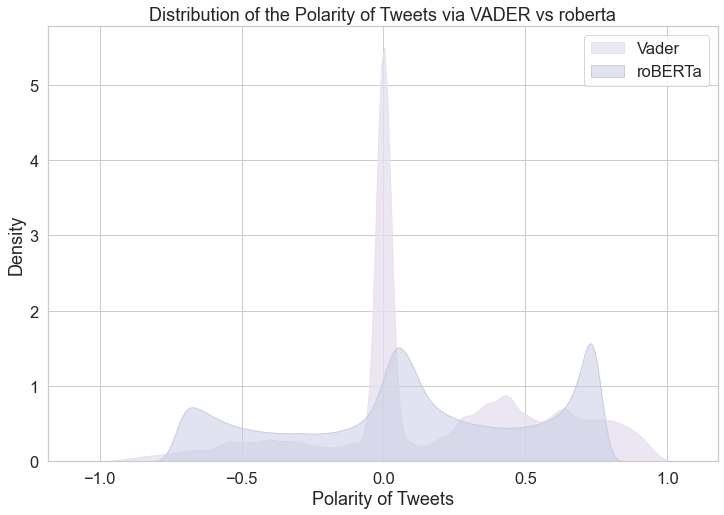

In [314]:
fig, ax = plt.subplots(1,1, figsize=(12,8))
sns.kdeplot(df_sentiment['VADER_Polarity'],shade=True, legend='Vader', alpha=0.8)
ax = sns.kdeplot(df_sentiment['ROBERTA_Polarity'], shade=True, legend='roBERTa', alpha=0.5)
ax.set_xlabel('Polarity of Tweets')
ax.set_title('Distribution of the Polarity of Tweets via VADER vs roberta')
plt.legend(['Vader','roBERTa'])
plt.show()

- As presented in the figure above, VADER assigned a polarity score of 0 for a large portion of tweets. That means it was not able to find many positive or negative words in tweets. 
- On the other hand, roBERTA catches the deep meaning of a text rather than the meaning of individual words, it was more sensitive in distinguish the negative and neutral tweets.

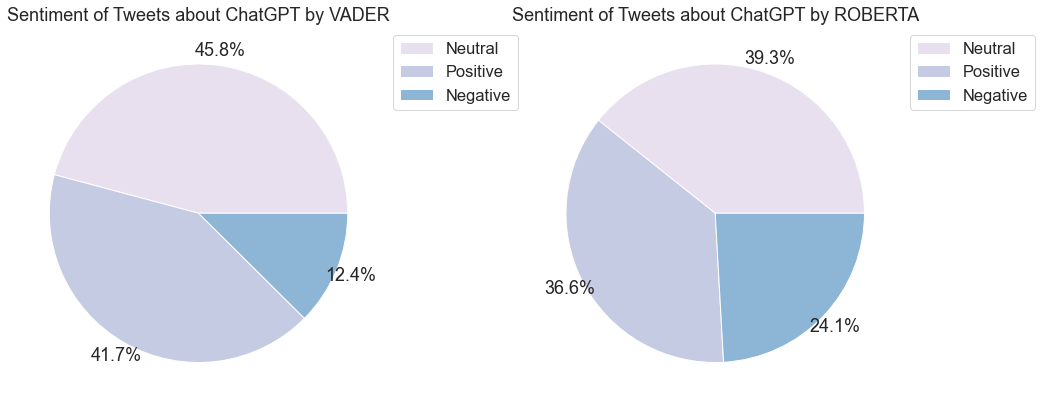

In [321]:
sns.set_palette('PuBuGn')
fig,ax=plt.subplots(1,2,figsize=(15,6))
plt.subplot(1,2,1)
pie_1 = df_sentiment['VADER_Sentiment'].value_counts()
plt.pie(pie_1, autopct="%.1f%%", pctdistance=1.1)
plt.legend(labels = pie_1.index, 
          bbox_to_anchor=[1,1])
plt.title('Sentiment of Tweets about ChatGPT by VADER')

plt.subplot(1,2,2)
pie_2 = df_sentiment['ROBERTA_Sentiment'].value_counts()
plt.pie(pie_2, autopct="%.1f%%", pctdistance=1.1)
plt.legend(labels = pie_2.index, 
          bbox_to_anchor=[1,1])
plt.title('Sentiment of Tweets about ChatGPT by ROBERTA')

plt.tight_layout()
plt.show()

- According to the rule-based VADER model, positive and neutral tweets are the most, whereas negative tweets are much lower (only 12.4%). 
- On the other side, according to the deep learning-based Twitter roBERTa model, the amount of negative tweets almost doubled with the percentage of neutral and positive both dropped by ~5%

In [336]:
#Test the process time of VADER and ROBERTA using a dataframe with 1000 samples. 
df_test = df[0:5000].copy()

#VADER process
start = time.time()
df_test['VADER_Polarity'] = df_test['Text'].apply(lambda x: vader_model.polarity_scores(x)['compound'])
end = time.time()
t1 = end-start

start = time.time()
df_test['ROBERTA_Polarity'] = df_test['Text'].apply(lambda x: sentiment_analyzer(x,roberta_model))
end = time.time()
t2 = end-start
print(f'To predict sentiment of 5000 tweets, VADER used {round(t1,2)}s, while ROBERTA used {round(t2,2)}s.')

To predict sentiment of 5000 tweets, VADER used 0.49s, while ROBERTA used 243.42s.


**Conclusion**
- VADER is much faster than ROBERTA on the same tasks (by a factor of approximately 500 on my personal desktop). 
- The accuracy of roBERTa is much higher and reflects more reality comparing to VADER.
- The choice between VADER and ROBERTA will depend on the specific task requirements and available computational resources.

# EDA_Sentiment of Tweets

The EDA of the sentiment of tweets is conducted via the roBERTA sentiment prediction. 

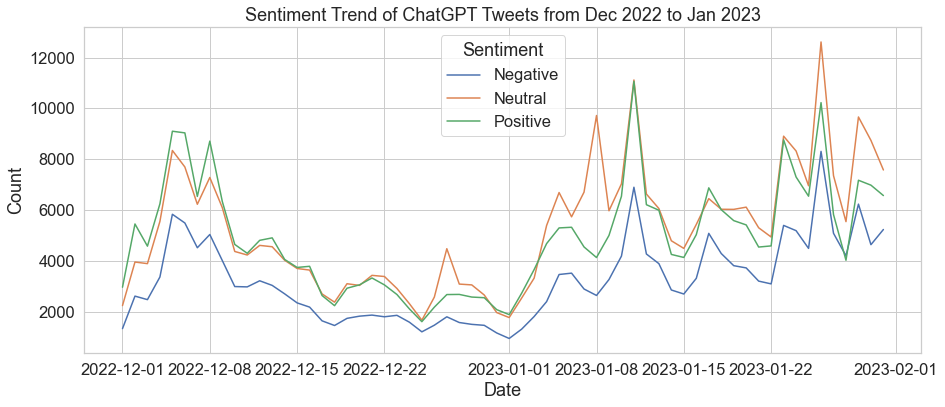

In [390]:
# Sentiment with time
#create a dataframe with sentiment count for each day
sentiment_count = df_sentiment.resample('D', on='Date')['ROBERTA_Sentiment'].value_counts().unstack()
sentiment_count.reset_index(inplace=True)
sentiment_count = sentiment_count.melt('Date', var_name='Sentiment', value_name='Count')
plt.subplots(1,1,figsize=(15,6))
sns.lineplot(data=sentiment_count, hue='Sentiment', y='Count', x='Date')
plt.title('Sentiment Trend of ChatGPT Tweets from Dec 2022 to Jan 2023')
plt.xlabel('Date')
plt.ylabel('Count')
plt.show()

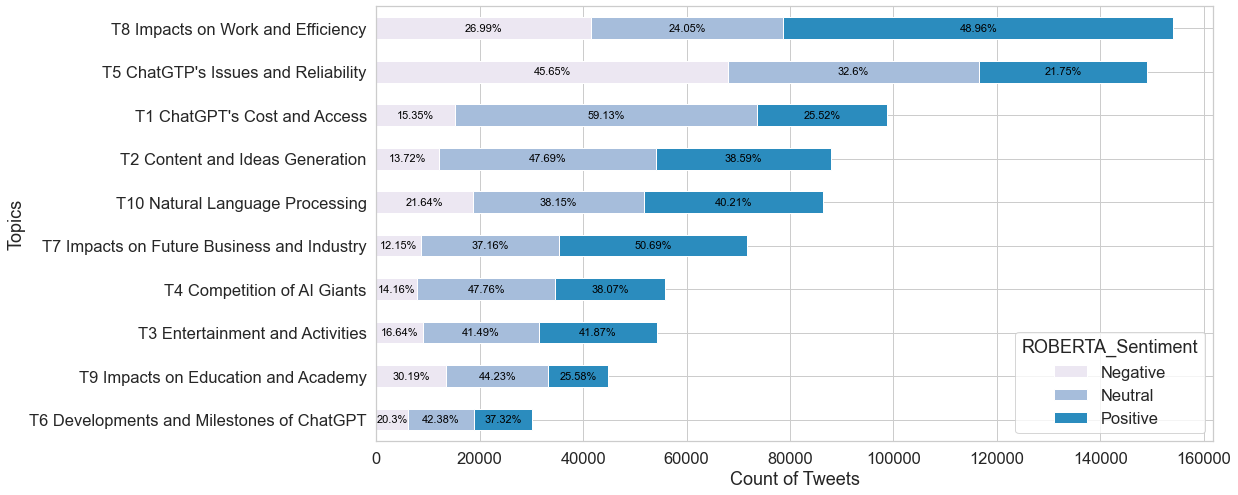

In [15]:
# Sentiment of each topic

topic_sen = df_sentiment.groupby('Topic_Name')['ROBERTA_Sentiment'].value_counts().unstack().reset_index()
#sort by the popularity of the topics (total count)
topic_sen['Total']=topic_sen['Negative']+topic_sen['Neutral']+topic_sen['Positive']
topic_sen = topic_sen.sort_values('Total')
topic_sen=topic_sen.drop(columns='Total')
topic_sen = topic_sen.set_index('Topic_Name')

ax=topic_sen.plot(kind='barh',stacked='True', color=['#ece7f2', '#a6bddb', '#2b8cbe'], figsize=(15,8))
#get the percentage of each sentiment in specific topic
percentages = topic_sen.div(topic_sen.sum(axis=1), axis=0)
percentages = percentages.reset_index().melt('Topic_Name', var_name='Sentiment', value_name='Percentage')
#label the percentage of each sentiment
for i, patch in enumerate(ax.patches):
    ax.text(patch.get_x()+patch.get_width()/2, 
            patch.get_y()+0.25, 
            f'{round(percentages.loc[i,"Percentage"]*100,2)}%', 
            ha='center', va='center', 
            color='black', fontsize=11)
ax.set_xlabel('Count of Tweets')
ax.set_ylabel('Topics')
plt.show()

- Topics ***Impacts on Work and Efficiency*** and ***Impacts on Future Business and Industry*** have the most positive sentiment (~50%), indicating that people are optimistic about the postive effects of ChatGPT on our furture work and life.

- The negative sentiments of topics ***ChatGPT's Issues and Reliability*** (47%) and ***Impacts on Education and Academy*** (30%) are relatively high, indicating the ChatGPT still needs to improve in the case of user experience, system stability, watermark for preventing plagiarism, etc. 

- Overall, the sentiment towards ChatGPT are neutral to positive.